In [14]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [15]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [16]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [17]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [18]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [221]:
tr = ['001706223600.jpg', '017062312000.jpg', '017062326400.jpg', '017062238291.jpg', '017062150068.jpg']
t5 = [1706223600, 17062312000, 17062326400, 17062238291, 17062150068]
#test_file = 'bee_test.png'
#image = load(test_file)
#base = "../tools/datasets/bee/validation/"
base = "../tools/datasets/bee/train/"
#base_val = "../tools/datasets/bee/annotations/validation.json"
base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
    for p in data_an['images'][:]:
        if (p['id'] not in t5):
            data_an['images'].remove(p)
    for p in data_an['annotations'][:]:
        if (p['image_id'] not in t5):
            data_an['annotations'].remove(p)
        
#test_ims = 
test_files = ['001706223600.jpg', '017062312000.jpg', '017062326400.jpg', '017062238291.jpg', '017062150068.jpg']
#for p in data_an['images'][:]:
 #   test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['001706223600.jpg', '017062312000.jpg', '017062326400.jpg', '017062238291.jpg', '017062150068.jpg']
5


5000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
FIELDS:
predictions BoxList(num_boxes=22, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=13, image_width=2560, image_height=1440, mode=xyxy)
IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
kps val post [753, 235, 750, 134, 737, 162, 767, 146, 755, 134]
kp pred listt [[818.1947631835938, 324.2100830078125], [943.55517578125, 529.2354736328125], [890.6473388671875, 456.5851135253906], [898.7288208007812, 578.319091796875], [989.17822265625, 554.2828369140625]]
diff vec [ -65.19476318  -89.21008301 -193.55517578 -395.23547363 -153.64733887
 -294.58511353 -131.7288208  -432.3190918  -234.17822266 -420.28283691]
IDDD 235
kps val post [688, 62, 733, 134, 720, 105, 733, 152, 764, 136]
kp pred listt [[818.1947631835938, 324.2100830078125], [943.55517578125, 529.2354736328125], [890.6473388671875, 456.5851135253906], [898.7288208007812, 578.319091796875], [989.17822265625, 554.2

TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
FIELDS:
predictions BoxList(num_boxes=66, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=29, image_width=2560, image_height=1440, mode=xyxy)
IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
kps val post [83, 304, 151, 352, 137, 332, 149, 376, 159, 353]
kp pred listt [[390.57708740234375, 586.5928344726562], [367.3546447753906, 802.906982421875], [371.7286376953125, 701.3019409179688], [365.2625427246094, 829.68994140625], [388.5333557128906, 824.32763671875]]
diff vec [-307.5770874  -282.59283447 -216.35464478 -450.90698242 -234.7286377
 -369.30194092 -216.26254272 -453.68994141 -229.53335571 -471.32763672]
IDDD 581
kps val post [487, 180, 489, 274, 491, 250, 471, 283, 505, 292]
kp pred listt [[501.537841796875, -16.92272186279297], [513.4343872070312, 130.69520568847656], [510.2807312011719, 44.73548889160156], [481.0812683105469, 179.7179718017578], [557.07763671875, 166.0730

TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
FIELDS:
predictions BoxList(num_boxes=47, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=22, image_width=2560, image_height=1440, mode=xyxy)
IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
kps val post [73, 97, 97, 193, 98, 167, 88, 217, 112, 207]
kp pred listt [[208.8720703125, -0.6449866890907288], [247.28021240234375, 43.887962341308594], [232.38992309570312, -1.7364096641540527], [221.1952362060547, 116.28506469726562], [281.61883544921875, 88.52206420898438]]
diff vec [-135.87207031   97.64498669 -150.2802124   149.11203766 -134.3899231
  168.73640966 -133.19523621  100.7149353  -169.61883545  118.47793579]
IDDD 767
kps val post [189, 33, 119, 87, 135, 70, 107, 101, 117, 113]
kp pred listt [[208.8720703125, -0.6449866890907288], [247.28021240234375, 43.887962341308594], [232.38992309570312, -1.7364096641540527], [221.1952362060547, 116.28506469726562], [281.61883544921875

TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
FIELDS:
predictions BoxList(num_boxes=25, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=10, image_width=2560, image_height=1440, mode=xyxy)
IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
kps val post [555, 109, 510, 190, 525, 167, 486, 203, 516, 218]
kp pred listt [[481.8014831542969, 200.9126434326172], [275.48687744140625, 148.56370544433594], [363.29217529296875, 207.1608428955078], [263.7787780761719, 102.39830017089844], [239.06573486328125, 135.11180114746094]]
diff vec [ 73.19851685 -91.91264343 234.51312256  41.43629456 161.70782471
 -40.1608429  222.22122192 100.60169983 276.93426514  82.88819885]
IDDD 877
kps val post [184, 72, 216, 146, 208, 121, 202, 167, 231, 164]
kp pred listt [[481.8014831542969, 200.9126434326172], [275.48687744140625, 148.56370544433594], [363.29217529296875, 207.1608428955078], [263.7787780761719, 102.39830017089844], [239.06573486328125, 1

TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
FIELDS:
predictions BoxList(num_boxes=16, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=9, image_width=2560, image_height=1440, mode=xyxy)
IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
kps val post [172, 217, 157, 141, 159, 174, 168, 122, 138, 127]
kp pred listt [[445.3291320800781, 45.5689811706543], [432.42742919921875, 154.68283081054688], [443.0052795410156, 64.36319732666016], [471.0750732421875, 104.81666564941406], [399.14068603515625, 119.35384368896484]]
diff vec [-273.32913208  171.43101883 -275.4274292   -13.68283081 -284.00527954
  109.63680267 -303.07507324   17.18333435 -261.14068604    7.64615631]
IDDD 1205
kps val post [481, 147, 425, 205, 453, 179, 417, 201, 431, 213]
kp pred listt [[445.3291320800781, 45.5689811706543], [432.42742919921875, 154.68283081054688], [443.0052795410156, 64.36319732666016], [471.0750732421875, 104.81666564941406], [399.140686035

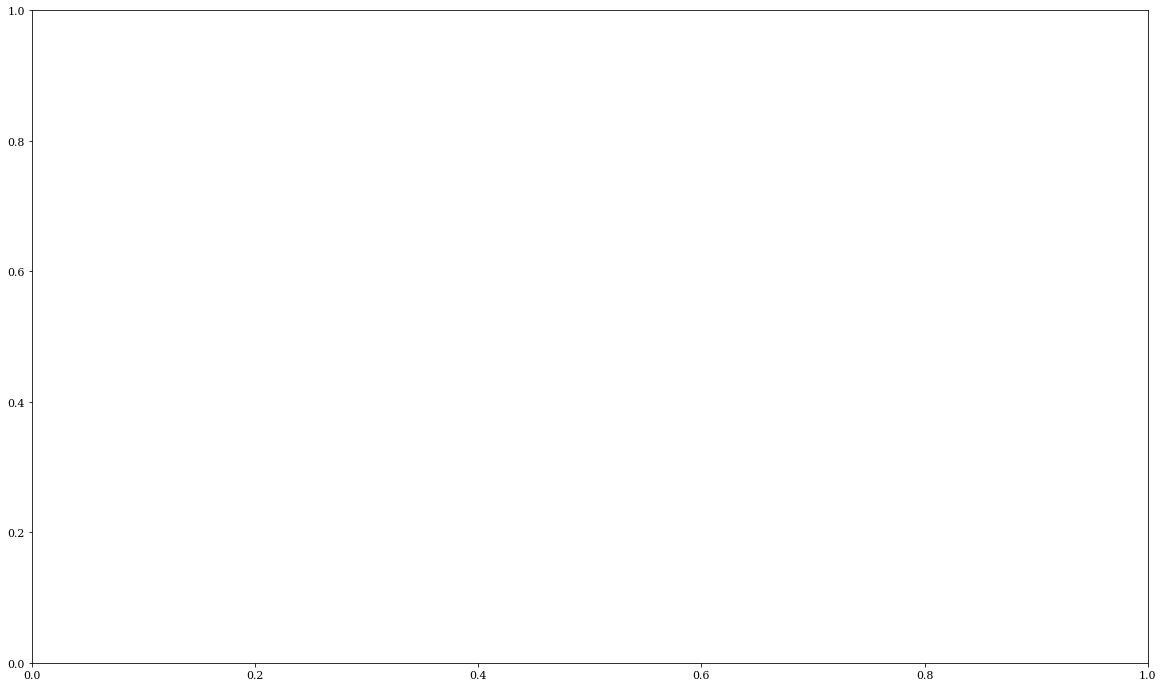

In [226]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "5"
its = range(1000,10001,1000)
#its = range(2000,6001,1000)
b = "23.1"
v = "2"

#test_ims = []
losses = ["p3standard0/3","p2p2combined_res.001/3","p4_ccombined_beta.5/2"]
t = []
its = [5000]
loss = losses[2]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        #test_ims.append(predictions[:, :, [2, 1, 0]])
        plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']  
                print("IDDD fn",p['file_name'])
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                print("IDDD",p['id'])
                #CHANGEfor test
                bb = p["segmentation"]#p['bbox']
                #bb = p['bbox']
                bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_valog = p["keypoints"]
                #print('kps val pre', kps_valog)
                # comment for test and remove og
                kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                print('kps val post', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps pred", kps_pred)
                print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                print("diff vec", diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    t.append(mse_test)
    print("mse yo", mse_test)


In [209]:
print(t)




[329984.522796851, 330868.79684865044, 330020.26389954705, 329693.33558666205, 330263.71911162656, 329863.9371278469, 329391.99789298803, 329589.3446807741, 330220.0431891031, 329549.60897694284]


In [ ]:
#TRAIN MSES

ts1 = [352682.5931911982, 302076.2227522014, 309374.7677067003, 340888.4412619777, 318001.4025198497,326589.84279534715, 327794.3635496137, 329050.9087452087, 327049.0381464108, 327247.3202193181, 327510.0636956457, 327301.2310706127, 327585.1673388088, 327229.34777887224, 327218.2726349025]
ts2 = [295510.9534823836, 333583.85472922365, 337098.20234513906, 305388.7057235417, 337805.0641046548,330114.05634174217, 329341.47614711744, 328722.63693592633, 328942.91564057575, 328219.11813727213, 327843.0921116409, 328601.7869257253, 328985.514936098, 329369.3410794562, 328179.038989585]
ts3 = [317390.3681851385, 285958.6276413431, 320219.452960621, 332810.8903517813, 328801.4347349837,328955.8193456309, 327972.33934498124, 327699.6274048633, 327484.3736661491, 326132.13519918284, 326754.58352156414, 326145.36137934774, 326262.5848361832, 325863.3624978922, 325741.9703534498]

tc1 = [296228.25563537923, 332868.90005481173, 321508.92385138373,329725.561559517, 329572.7181074652, 328710.897064261, 329381.22947784996, 328251.0941018826, 329259.6156419768, 329249.87760359107, 328554.47540642304, 328439.5613362114, 328669.14277663553]
tc2 = [332987.47075096937, 322577.1390209535, 328312.3382985977]
tc3 = [334050.02852856583, 332486.2733569091, 334778.46926057304]

tu1
tu2
tu3



In [137]:
t1 = [15011.76967998355, 15127.667253746225,15665.570764976093, 15344.883332181511,17610.144816393233,14555.191678791203, 15585.610409167772, 17307.3229319881, 17114.891394387996, 17527.586456286426]
t2 = [15382.943912998582,12948.257587140562,12016.622638868774,11491.101955618551,12425.99906523927,10839.633671493944, 12919.162591274291, 12708.99253120122, 11806.68998103495, 13403.728798428376]
t3 = [13199.280021099965, 15313.813209031174,14197.453859275498,13264.627031974394,15264.527539522422,14126.794543411457, 15068.276700619255, 15263.476956058863, 15276.339042771559, 15766.860881127941]

In [146]:
c1 = [12818.812189829803, 21115.75207160644, 21939.2224049479,21077.41764695348, 21404.689861971496, 20077.68914897437, 20322.51991356641, 20221.47242777069,19990.751792321524, 21317.27217303216, 21424.53493544978, 20416.864247708465, 20703.316115657195]
c2 = [16409.297003902524, 15631.583541160957, 19732.613046098322,12430.498084118486, 13409.38787919351, 12851.060188152947, 14108.092715745246, 14045.585077044117,13601.31367920663, 13985.733467832097, 14142.206917764075, 14242.14229101802, 14418.386077405412]
c3 = [18837.259390968087, 17318.993683547153, 15508.415734136688,15135.850211778312, 14797.982779711196, 15360.50103849797, 14600.943342535338, 15486.321149402918,15296.690689438203, 15374.386145050452, 15801.7468552201, 15272.82758039327,15014.601088224083]

In [147]:
s1 = [46481.89381252696, 26158.482211818522, 16077.375775328142, 23747.939040602385, 17666.628491840274,21167.521162300534, 22844.959606785873, 22509.6405317005, 23116.69670684126, 23591.34962707445,22927.335802066005, 22762.856524731113, 24454.230365664574, 23489.713105607545, 22791.382127293466]
s2 = [20774.273260115606, 17145.905416638263, 18696.489346738916, 13911.129585014742, 15491.395701814368,14380.581770966675, 13588.143191137595, 14977.183944227516, 16239.264337870114, 15648.164613716128,15377.905247366563, 15531.891358772215, 16205.456256474446, 14781.610951796145, 15034.671864018006]
s3 = [32997.075132494276, 18407.862445382787, 19226.887758866033, 18232.86134275201, 21141.381769916643,17363.329084609966, 16495.369027503923, 17786.07861902156, 16947.919870706468, 16876.13971356877,16895.848685161847, 15993.511341735875, 15985.035651281294, 16886.809014154005, 17122.91283553561]

In [148]:
ca = []
for w1,w2,w3 in zip(c1,c2,c3):
    ca.append((w1+ w2+w3)/3)

In [153]:
import numpy as np
bu = np.array([50600])
bu = (np.repeat(bu, 19, axis=0)).tolist()
print(bu)
td = np.array([31400])
td = np.repeat(td, 19, axis=0).tolist()
print(td)

[50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600]
[31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400]


In [150]:
#get sds
#plt.fill_between(x, y-error, y+error,alpha=0.2)
# x = np.linspace(0, 30, 30)
# y = np.sin(x/6*np.pi)
# error = np.random.normal(0.1, 0.02, size=y.shape)
# y += np.random.normal(0, 0.1, size=y.shape)
# #plt.plot(x, y, 'k-')
# plt.fill_between(x, y-error, y+error)
# plt.show()
s_e = []
c_e = []
u_e = []

for w1,w2,w3 in zip(s1,s2,s3):
    s_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(c1,c2,c3):
    c_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(t1,t2,t3):
    u_e.append(np.std([w1,w2,w3])/np.sqrt(3))

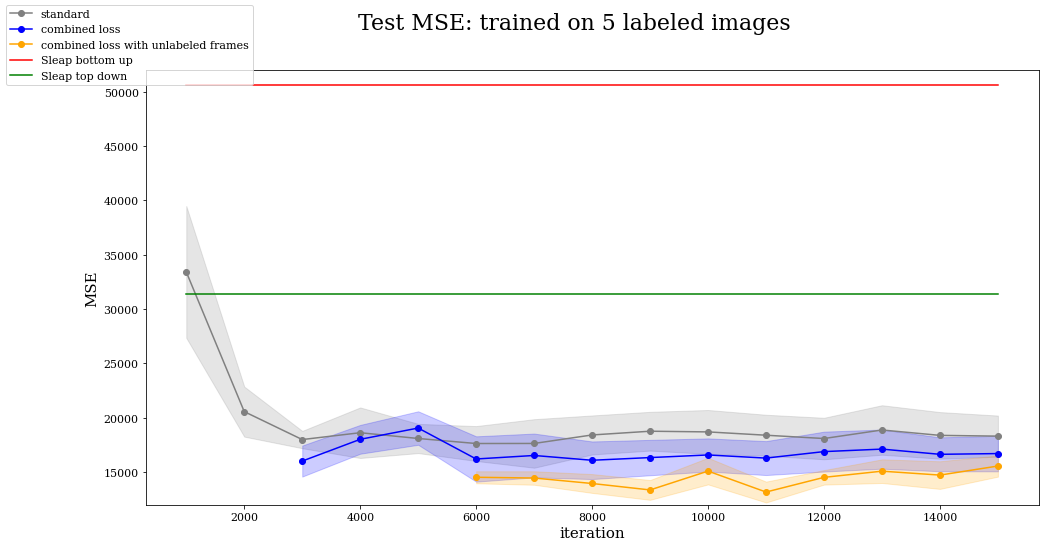

In [172]:
SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title
#plt.rc('font', 8)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
it_c = range(3000,15001,1000)
it1 = range(3000,15001,1000)
itu = range(6000,15001,1000)
ita = range(1000,15001,1000)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
plt.xlabel("iteration")
plt.ylabel("MSE")
fig.suptitle("Test MSE: trained on 5 labeled images ",fontsize = 22)
colors = ['r','b','y','g']

plt.plot(ita, sa, '-o', c='grey', label="standard")
plt.fill_between(ita, np.array(sa)-np.array(s_e), np.array(sa)+np.array(s_e),alpha = .2,color='grey')

plt.plot(it1, ca, '-o', c='blue', label="combined loss")
plt.fill_between(it1, np.array(ca)-np.array(c_e), np.array(ca)+np.array(c_e),alpha = .2,color='blue')

plt.plot(itu, va, '-o', c='orange', label="combined loss with unlabeled frames")
plt.fill_between(itu, np.array(va)-np.array(u_e), np.array(va)+np.array(u_e),alpha = .2,color='orange')

#plt.plot(itu, ca3, '-o', c='pink', label="beta=.001")
#plt.plot(itu, ca0, '-o', c='red', label="beta=.1")
#plt.plot(itu, ca1, '-o', c='green', label="beta=1")
#plt.plot(itu, b5a, '-o', c='orange', label="beta=.5")
#plt.plot(itu, ca3, '-o', c='pink', label="beta=.001")

plt.plot(ita, bu[0:15], c='red', label="Sleap bottom up")
plt.plot(ita, td[0:15], c='green', label="Sleap top down")
ax.set_ylim(top = 52000,bottom = 12000)
fig.legend(loc='upper left')
fig.savefig("all_5" +'.pdf')
plt.show()

In [167]:
frame_index = None



save_file = 'bee_5_standard.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
dd1,dd2 = (test_ims[0].shape[0]),(test_ims[0].shape[1])
print(dd1,dd2)
out = cv2.VideoWriter(save_file, fourcc, 1.0, (dd2,dd1))
for im in test_ims:
    out.write(im)
    
out.release()


1440 2560
